In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('/kaggle/input/wildfiredata/wildfire_collection_feature_engineering_final.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659376 entries, 0 to 659375
Data columns (total 32 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _id       659376 non-null  object 
 1   cfb       659376 non-null  int64  
 2   locality  659376 non-null  object 
 3   rep_date  659376 non-null  object 
 4   lat       659376 non-null  float64
 5   lon       659376 non-null  float64
 6   temp      659376 non-null  float64
 7   wd        659376 non-null  int64  
 8   elev      659376 non-null  int64  
 9   rh        659376 non-null  int64  
 10  pcuring   659376 non-null  int64  
 11  day       659376 non-null  int64  
 12  ros       659376 non-null  float64
 13  year      659376 non-null  int64  
 14  month     659376 non-null  int64  
 15  hfi       659376 non-null  int64  
 16  tfc0      659376 non-null  float64
 17  sfl       659376 non-null  float64
 18  bui_lag2  659376 non-null  float64
 19  bui       659376 non-null  float64
 20  cfl 

In [4]:
df.drop(columns='_id', inplace=True)

In [5]:
from datetime import datetime

def return_date(date_string):
    #date_dict = eval(date_string)  # Convert the string to a dictionary
    date_value = date_string['$date']  # Get the value of the '$date' key
    return datetime.strptime(date_value, "%Y-%m-%dT%H:%M:%S.%fZ").date()  # Convert the string to a date object

df['rep_date'] = df['rep_date'].apply(return_date)
df.head()

,cfb,locality,rep_date,lat,lon,temp,wd,elev,rh,pcuring,...,dmc_lag5,dmc,sfc,dmc_lag7,bui_lag4,bfc,tfc,isi,bui_lag5,fwi_lag7
0,0,100 Mile House,2021-01-09,51.627403,-121.285294,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
1,0,100 Mile House,2021-01-10,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
2,0,100 Mile House,2021-01-11,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
3,0,100 Mile House,2021-01-12,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
4,0,100 Mile House,2021-01-13,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015


In [6]:
df['cfb'] = df['cfb'].astype(float)

In [7]:
def create_lagged_features(df, features, lags):
    for feature in features:
        for lag in lags:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    return df

# Define lag features
features_to_lag = ['cfb', 'dmc', 'temp', 'tfc', 'ros', 'pcuring', 'bfc', 'hfi']
lags = [1, 2, 3, 5, 6, 7]

# Create lagged features
df = create_lagged_features(df, features_to_lag, lags)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

Split train and test data

In [8]:
import datetime

split_date = datetime.date(2023, 7, 1)
train_data = df[df['rep_date'] < split_date]
test_data = df[df['rep_date'] >= split_date]

In [9]:
train = train_data.reset_index()
train = (train.merge((train[['rep_date']].drop_duplicates(ignore_index=True).rename_axis('time_idx'))\
                     .reset_index(), on = ['rep_date'])).drop("rep_date", axis=1)

In [10]:
# Check for duplicates
duplicates = train[train.duplicated(['locality', 'time_idx'], keep=False)]
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
         index   cfb        locality        lat         lon       temp   wd  \
193        200  63.0  100 Mile House  51.542999 -121.434998  26.851000  177   
194        201   0.0  100 Mile House  51.526001 -121.428001  26.940001  177   
195        202   0.0  100 Mile House  51.530998 -121.410004  26.900000  177   
196        203   0.0  100 Mile House  51.530998 -121.411003  25.910000  353   
197        204  35.0  100 Mile House  51.528999 -121.422997  25.934000  353   
...        ...   ...             ...        ...         ...        ...  ...   
658166  659367   0.0           Zhoda  49.299700  -96.576300  24.204000  152   
658167  659368   0.0           Zhoda  49.298000  -96.568900  24.204000  152   
658172  659373   0.0           Zhoda  49.282500  -96.587500  28.539000  103   
658173  659374   0.0           Zhoda  49.291300  -96.580100  28.561000  103   
658174  659375   0.0           Zhoda  49.279000  -96.578000  28.538000  103   

        elev  rh  pcuring  ...  bfc

In [11]:
# Aggregate duplicate rows (using mean as an example)
train_unique = train.groupby(['locality', 'time_idx']).mean().reset_index()

# Verify that we now have unique combinations
assert train_unique.duplicated(['locality', 'time_idx']).sum() == 0, "Still have duplicates after aggregation"

In [12]:
# Create a complete time series for each locality
full_index = pd.MultiIndex.from_product(
    [train_unique['locality'].unique(), 
     range(train_unique['time_idx'].min(), train_unique['time_idx'].max() + 1)],
    names=['locality', 'time_idx']
)

# Reindex the dataframe and reset index to reintroduce locality and time_idx as columns
train_filled = train_unique.set_index(['locality', 'time_idx']).reindex(full_index).reset_index()

# Check the presence of 'locality' column
print(train_filled.columns)

# Forward fill the missing values within each group, but keep locality and time_idx intact
train_filled.update(train_filled.groupby('locality').ffill())

# If needed, backward fill remaining NaN values after forward fill
train_filled.update(train_filled.groupby('locality').bfill())

# Resulting DataFrame
print(train_filled)

Index(['locality', 'time_idx', 'index', 'cfb', 'lat', 'lon', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7',
       'cfb_lag1', 'cfb_lag2', 'cfb_lag3', 'cfb_lag5', 'cfb_lag6', 'cfb_lag7',
       'dmc_lag1', 'dmc_lag2', 'dmc_lag3', 'dmc_lag6', 'temp_lag1',
       'temp_lag2', 'temp_lag3', 'temp_lag5', 'temp_lag6', 'temp_lag7',
       'tfc_lag1', 'tfc_lag2', 'tfc_lag3', 'tfc_lag5', 'tfc_lag6', 'tfc_lag7',
       'ros_lag1', 'ros_lag2', 'ros_lag3', 'ros_lag5', 'ros_lag6', 'ros_lag7',
       'pcuring_lag1', 'pcuring_lag2', 'pcuring_lag3', 'pcuring_lag5',
       'pcuring_lag6', 'pcuring_lag7', 'bfc_lag1', 'bfc_lag2', 'bfc_lag3',
       'bfc_lag5', 'bfc_lag6', 'bfc_lag7', 'hfi_lag1', 'hfi_lag2', 'hfi_lag3',
       'hfi_lag5', 'hfi_lag6', 'hfi_lag7'],
      dtype='object')
              locality  time_

In [13]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994340 entries, 0 to 994339
Data columns (total 78 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   locality      994340 non-null  object 
 1   time_idx      994340 non-null  int64  
 2   index         994340 non-null  float64
 3   cfb           994340 non-null  float64
 4   lat           994340 non-null  float64
 5   lon           994340 non-null  float64
 6   temp          994340 non-null  float64
 7   wd            994340 non-null  float64
 8   elev          994340 non-null  float64
 9   rh            994340 non-null  float64
 10  pcuring       994340 non-null  float64
 11  day           994340 non-null  float64
 12  ros           994340 non-null  float64
 13  year          994340 non-null  float64
 14  month         994340 non-null  float64
 15  hfi           994340 non-null  float64
 16  tfc0          994340 non-null  float64
 17  sfl           994340 non-null  float64
 18  bui_

### Transform Dataset to TimeSeriesDataset of Pytorch

In [14]:
train_filled['time_idx'].nunique()

1198

In [15]:
all_features = ['cfb', 'locality', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',    
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7']

In [16]:
train.index.nunique()

658175

In [17]:
lags = ['bui_lag2',  'dmc_lag5', 'dmc_lag7', 'bui_lag4', 'bui_lag5', 'fwi_lag7']
lag_values = {lag: df[lag].values for lag in lags}
for keys, values in lag_values.items():
    if min(values) > 0:
        print('negative lag')

In [18]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 9.9 MB/s eta 0:00:00


In [19]:
# Calculate the number of observations per locality
series_lengths = train_filled.groupby('locality')['time_idx'].max() - train_filled.groupby('locality')['time_idx'].min() + 1
print(series_lengths.describe())

count     830.0
mean     1198.0
std         0.0
min      1198.0
25%      1198.0
50%      1198.0
75%      1198.0
max      1198.0
Name: time_idx, dtype: float64


In [20]:
# Check for gaps in time series
def check_time_gaps(group):
    return group['time_idx'].diff().max()

gaps = train_filled.groupby('locality').apply(check_time_gaps)
print(gaps.describe())

count    830.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64


/tmp/ipykernel_25/2574669589.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = train_filled.groupby('locality').apply(check_time_gaps)


In [21]:
from sklearn.utils.class_weight import compute_class_weight
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, MAPE, QuantileLoss
import torch

# 1. Analyze the distribution of CFB values
zero_cfb_ratio = (train_filled['cfb'] == 0).mean()
print(f"Percentage of zero CFB values: {zero_cfb_ratio * 100:.2f}%")

# 2. Create a binary target for fire occurrence
train_filled['fire_occurrence'] = (train_filled['cfb'] > 0).astype(int)

# 3. Compute class weights for balanced learning
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_filled['fire_occurrence'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 4. Custom loss function to handle imbalance
class WeightedQuantileLoss(QuantileLoss):
    def __init__(self, zero_weight=1.0, non_zero_weight=10.0, **kwargs):
        super().__init__(**kwargs)
        self.zero_weight = zero_weight
        self.non_zero_weight = non_zero_weight

    def loss(self, y_pred, y_actual):
        base_loss = super().loss(y_pred, y_actual)
                # Check shapes for debugging
        print(f"Base loss shape: {base_loss.shape}")
        print(f"y_actual shape: {y_actual.shape}")
        weights = torch.where(y_actual == 0, self.zero_weight, self.non_zero_weight)
                # Check weights shape for debugging
        print(f"Weights shape: {weights.shape}")
        # Expand weights to match the shape of base_loss
        weights = weights.unsqueeze(-1).expand_as(base_loss)
        
        return (base_loss * weights).mean()

Percentage of zero CFB values: 86.99%


In [22]:
train_filled[train_filled['fire_occurrence'] >  0]

,locality,time_idx,index,cfb,lat,lon,temp,wd,elev,rh,...,bfc_lag5,bfc_lag6,bfc_lag7,hfi_lag1,hfi_lag2,hfi_lag3,hfi_lag5,hfi_lag6,hfi_lag7,fire_occurrence
193,100 Mile House,193,201.0,21.0,51.533333,-121.424334,26.8970,177.0,1204.0,23.0,...,6.253188,6.149034,6.149034,5924.666667,3986.666667,1903.000000,7856.333333,10833.0,10833.000000,1
194,100 Mile House,194,203.5,17.5,51.529999,-121.417000,25.9220,353.0,1200.0,29.0,...,6.461496,6.461496,6.305265,6099.000000,5447.500000,7935.500000,1903.000000,1903.0,6368.000000,1
195,100 Mile House,195,205.5,37.0,51.535824,-121.435665,28.5645,158.0,1209.5,27.0,...,6.887120,6.627117,6.461496,3624.500000,6333.500000,6099.000000,7935.500000,5028.5,1903.000000,1
196,100 Mile House,196,209.5,25.0,51.539834,-121.427333,29.5080,186.0,1205.5,22.0,...,5.960493,7.065743,6.991242,7429.333333,6030.166667,6595.166667,4834.666667,6078.0,5886.333333,1
197,100 Mile House,197,209.5,25.0,51.539834,-121.427333,29.5080,186.0,1205.5,22.0,...,5.960493,7.065743,6.991242,7429.333333,6030.166667,6595.166667,4834.666667,6078.0,5886.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991939,Zama City,1193,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1
991940,Zama City,1194,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1
991941,Zama City,1195,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1
991942,Zama City,1196,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1


In [23]:
## Define the data schema
static_reals=['elev']
time_varying_known_reals=['month', 'day', 'year']
time_varying_unknown_reals=['cfb', 'temp', 'wd',
       'rh', 'pcuring', 'ros', 'hfi', 'tfc0',
       'sfl', 'bui', 'cfl', 'sfc0', 'dmc', 'sfc',    
       'bfc', 'tfc', 'isi', 'fire_occurrence',
    'cfb_lag1', 'cfb_lag2', 'cfb_lag3', 'cfb_lag5', 'cfb_lag6', 'cfb_lag7',
    'dmc_lag1', 'dmc_lag2', 'dmc_lag3', 'dmc_lag5', 'dmc_lag6', 'dmc_lag7',
    'temp_lag1', 'temp_lag2', 'temp_lag3', 'temp_lag5', 'temp_lag6', 'temp_lag7',
    'tfc_lag1', 'tfc_lag2', 'tfc_lag3', 'tfc_lag5', 'tfc_lag6', 'tfc_lag7',
    'ros_lag1', 'ros_lag2', 'ros_lag3', 'ros_lag5', 'ros_lag6', 'ros_lag7',
    'pcuring_lag1', 'pcuring_lag2', 'pcuring_lag3', 'pcuring_lag5', 'pcuring_lag6', 'pcuring_lag7',
    'bfc_lag1', 'bfc_lag2', 'bfc_lag3', 'bfc_lag5', 'bfc_lag6', 'bfc_lag7',
    'hfi_lag1', 'hfi_lag2', 'hfi_lag3', 'hfi_lag5', 'hfi_lag6', 'hfi_lag7']
max_prediction_length = 7  # predict 7 days ahead
max_encoder_length = 30  # use 30 days of history

# keep the validation set held-out
training_cutoff = train["time_idx"].max() - max_prediction_length

In [24]:
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

target_normalizer = GroupNormalizer(
    groups=['locality'], 
    transformation="softplus"
)

train_dataset = TimeSeriesDataSet(
    train_filled[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='cfb',
    group_ids=['locality'],
    static_reals=static_reals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length//2,  
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,
    target_normalizer=target_normalizer,
    add_relative_time_idx=True,
    add_target_scales=True,
    lags = {
        "cfb": [1, 2, 3, 5, 6, 7]
    }
)

In [25]:
# create validation set (predict=True)
validation_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_filled,
    predict=True,
    stop_randomization=True,
)

In [26]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Define the model
# Use the weighted loss in the model definition
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
   # output_size=7,  # number of quantiles
    loss=WeightedQuantileLoss(zero_weight=1.0, non_zero_weight=10.0),  # Adjust weights as needed
    log_interval=10,
    reduce_on_plateau_patience=10
)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [27]:
quantiles = tft.loss.quantiles
quantiles

[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

In [28]:
# Function to print batch shapes
def print_batch_shapes(dataloader, name):
    for i, batch in enumerate(dataloader):
        x, y = batch
        print(f"{name} Batch {i+1}:")
        print(f"  Inputs shape: {x['encoder_cont'].shape}")
        print(f"  Decoder shape: {x['decoder_cont'].shape}")
        break


In [29]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

# Print shapes for train and validation dataloaders
print_batch_shapes(train_dataloader, "Train")
print_batch_shapes(val_dataloader, "Validation")

Train Batch 1:
  Inputs shape: torch.Size([64, 30, 80])
  Decoder shape: torch.Size([64, 7, 80])
Validation Batch 1:
  Inputs shape: torch.Size([640, 30, 80])
  Decoder shape: torch.Size([640, 7, 80])


In [30]:
# load the best model w.r.t. the validation loss
best_model_path = "/kaggle/input/trained-checkpoint-for-tft/checkpoints/best-checkpoint.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [31]:
if next(best_tft.parameters()).is_cuda:
    best_tft = best_tft.cpu()
predictions = best_tft.predict(val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2024-08-08 02:44:05.221645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 02:44:05.221744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 02:44:05.372745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this 

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = predictions.to(device)
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)]).to(device)

# Initialize metrics on the same device
rmse = RMSE().to(device)
mae = MAE().to(device)
mape = MAPE().to(device)
smape = SMAPE().to(device)

# Calculate metrics
mae = mae(predictions, actuals)
rmse = rmse(predictions, actuals)
mape = mape(predictions, actuals)
smape = smape(predictions, actuals)

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

MAE: 0.07
RMSE: 0.35
MAPE: 116.40
SMAPE: 0.01


In [33]:
predictions.shape

torch.Size([830, 7])

In [34]:
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [35]:
val_prediction_results.output['prediction'].shape

torch.Size([830, 7, 7])

Base loss shape: torch.Size([1, 7, 7])
y_actual shape: torch.Size([1, 7])
Weights shape: torch.Size([1, 7])


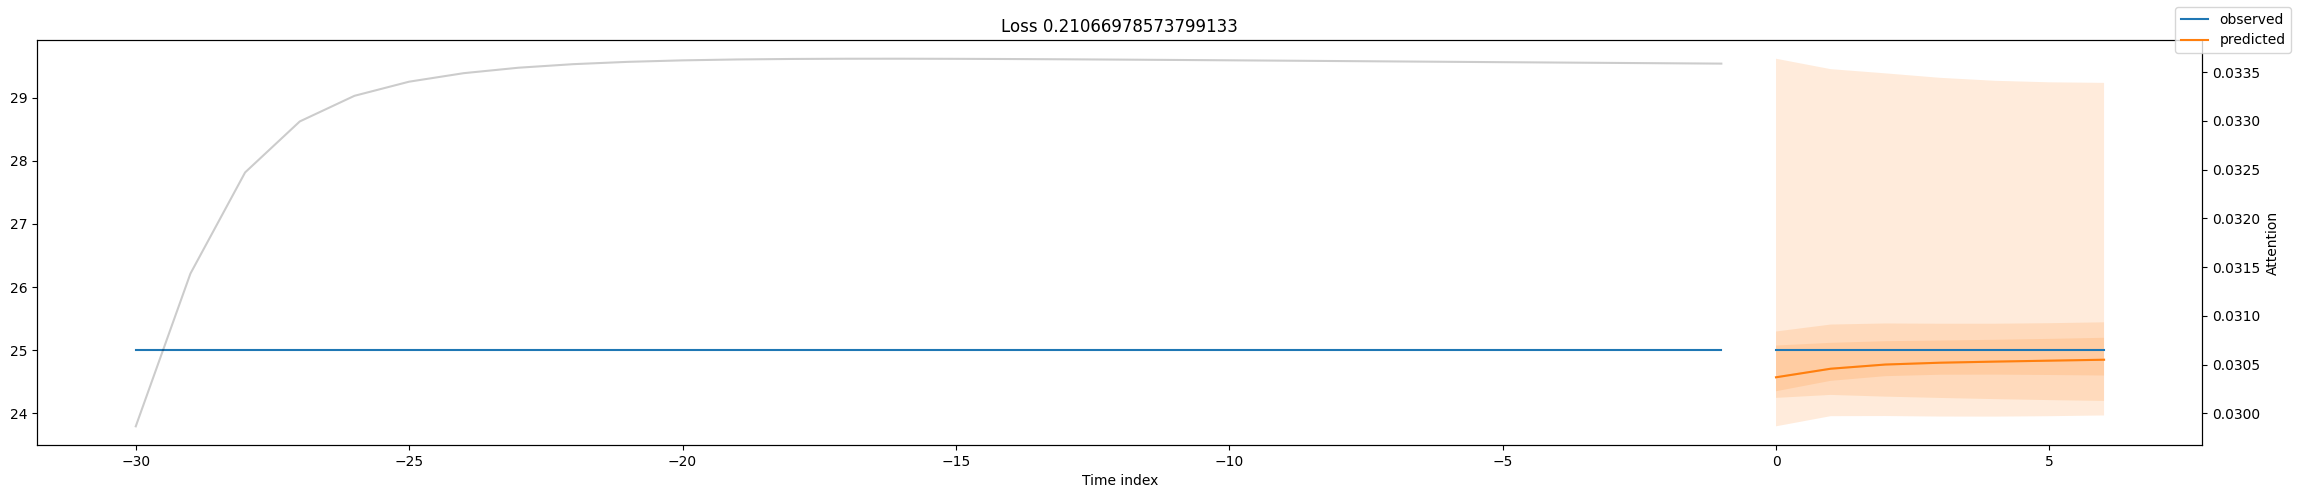

In [36]:
# Plot actuals vs prediction and attention
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x2100 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

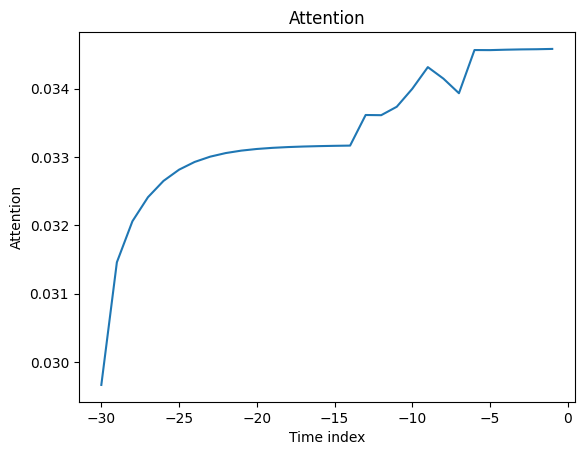

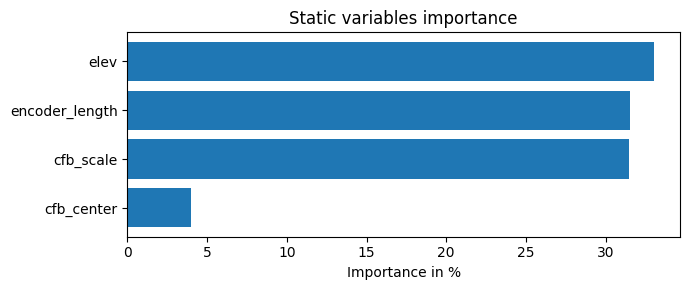

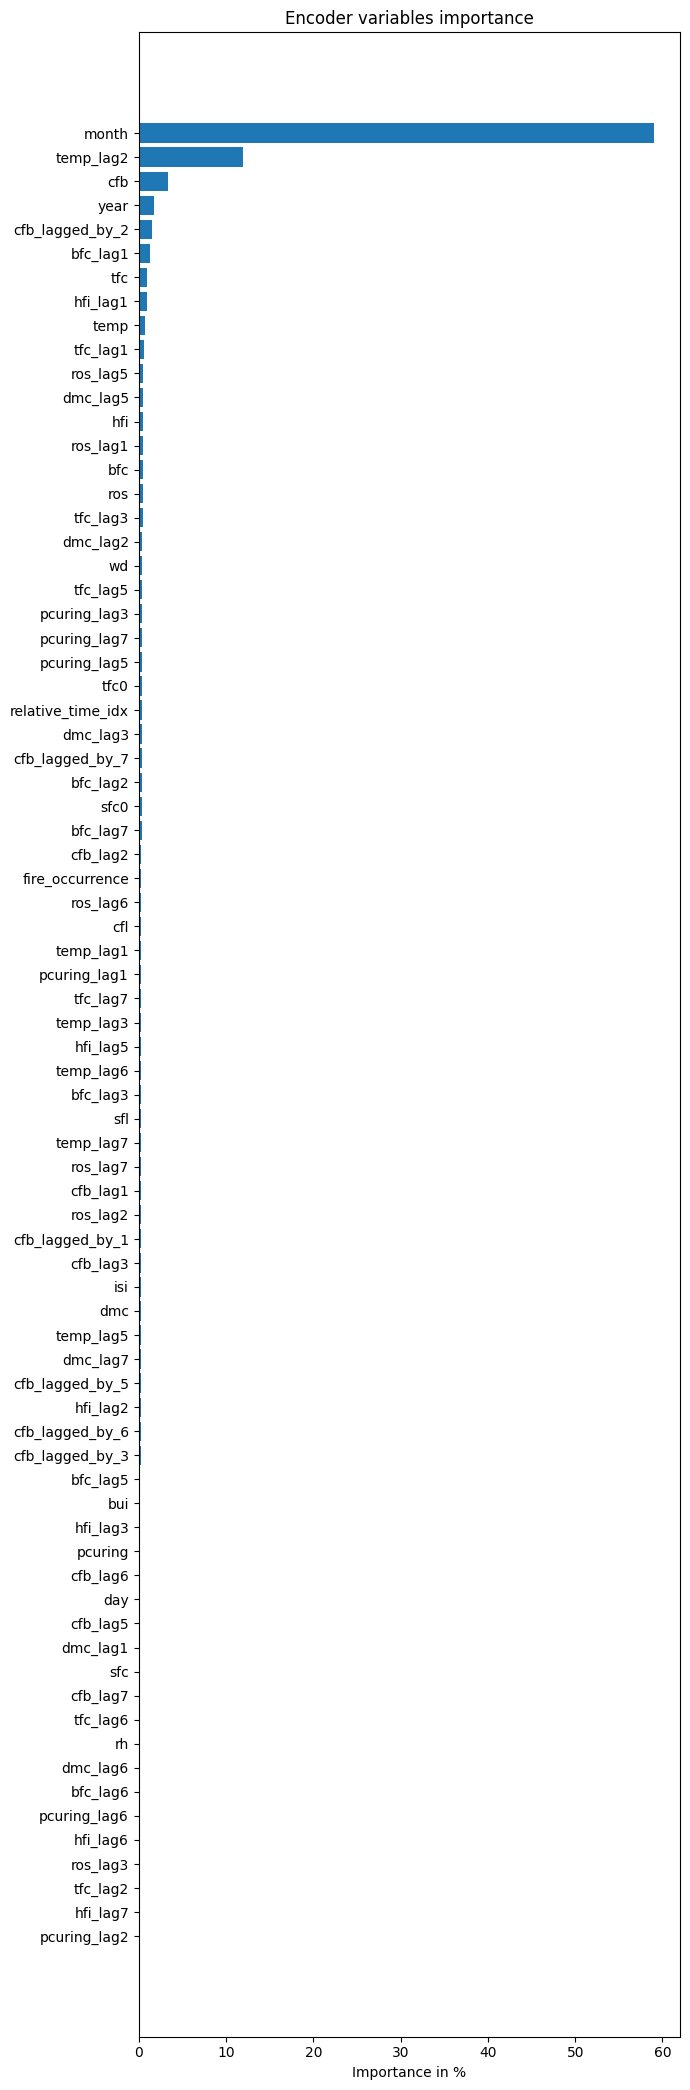

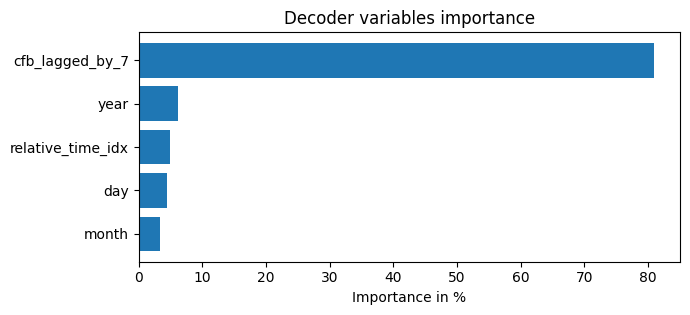

In [37]:
# plot variable importance
interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

# **Inferencing and Testing for 2023**

In [38]:
test = test_data.reset_index()
test = (test.merge((test[['rep_date']].drop_duplicates(ignore_index=True).rename_axis('time_idx'))\
                     .reset_index(), on = ['rep_date'])).drop("rep_date", axis=1)

In [39]:
# Aggregate duplicate rows (using mean as an example)
test_unique = test.groupby(['locality', 'time_idx']).mean().reset_index()

# Verify that we now have unique combinations
assert test_unique.duplicated(['locality', 'time_idx']).sum() == 0, "Still have duplicates after aggregation"

In [40]:
# Create a complete time series for each locality
full_index = pd.MultiIndex.from_product(
    [test_unique['locality'].unique(), 
     range(test_unique['time_idx'].min(), test_unique['time_idx'].max() + 1)],
    names=['locality', 'time_idx']
)

# Reindex the dataframe and reset index to reintroduce locality and time_idx as columns
test_filled = test_unique.set_index(['locality', 'time_idx']).reindex(full_index).reset_index()

# Check the presence of 'locality' column
print(test_filled.columns)

# Forward fill the missing values within each group, but keep locality and time_idx intact
test_filled.update(test_filled.groupby('locality').ffill())

# If needed, backward fill remaining NaN values after forward fill
test_filled.update(test_filled.groupby('locality').bfill())

# Resulting DataFrame
print(test_filled)

Index(['locality', 'time_idx', 'index', 'cfb', 'lat', 'lon', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7',
       'cfb_lag1', 'cfb_lag2', 'cfb_lag3', 'cfb_lag5', 'cfb_lag6', 'cfb_lag7',
       'dmc_lag1', 'dmc_lag2', 'dmc_lag3', 'dmc_lag6', 'temp_lag1',
       'temp_lag2', 'temp_lag3', 'temp_lag5', 'temp_lag6', 'temp_lag7',
       'tfc_lag1', 'tfc_lag2', 'tfc_lag3', 'tfc_lag5', 'tfc_lag6', 'tfc_lag7',
       'ros_lag1', 'ros_lag2', 'ros_lag3', 'ros_lag5', 'ros_lag6', 'ros_lag7',
       'pcuring_lag1', 'pcuring_lag2', 'pcuring_lag3', 'pcuring_lag5',
       'pcuring_lag6', 'pcuring_lag7', 'bfc_lag1', 'bfc_lag2', 'bfc_lag3',
       'bfc_lag5', 'bfc_lag6', 'bfc_lag7', 'hfi_lag1', 'hfi_lag2', 'hfi_lag3',
       'hfi_lag5', 'hfi_lag6', 'hfi_lag7'],
      dtype='object')
     locality  time_idx     i

In [41]:
# Check for gaps in time series
def check_time_gaps(group):
    return group['time_idx'].diff().max()

gaps = test_filled.groupby('locality').apply(check_time_gaps)
print(gaps.describe())

count    17.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64


/tmp/ipykernel_25/3462764073.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = test_filled.groupby('locality').apply(check_time_gaps)


In [42]:
# 1. Analyze the distribution of CFB values
zero_cfb_ratio = (test_filled['cfb'] == 0).mean()
print(f"Percentage of zero CFB values: {zero_cfb_ratio * 100:.2f}%")

# 2. Create a binary target for fire occurrence
test_filled['fire_occurrence'] = (test_filled['cfb'] > 0).astype(int)

Percentage of zero CFB values: 70.86%


In [43]:
test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   locality         1122 non-null   object 
 1   time_idx         1122 non-null   int64  
 2   index            1122 non-null   float64
 3   cfb              1122 non-null   float64
 4   lat              1122 non-null   float64
 5   lon              1122 non-null   float64
 6   temp             1122 non-null   float64
 7   wd               1122 non-null   float64
 8   elev             1122 non-null   float64
 9   rh               1122 non-null   float64
 10  pcuring          1122 non-null   float64
 11  day              1122 non-null   float64
 12  ros              1122 non-null   float64
 13  year             1122 non-null   float64
 14  month            1122 non-null   float64
 15  hfi              1122 non-null   float64
 16  tfc0             1122 non-null   float64
 17  sfl           

In [44]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder
for encoder in train_dataset.categorical_encoders.values():
    if isinstance(encoder, NaNLabelEncoder):
        encoder.add_nan = True

In [45]:
# Create test dataset
test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,
                                        test_filled, 
                                        predict=True, 
                                        stop_randomization=True)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

# Get prediction results
test_prediction_results = best_tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True, # return the prediction index in the same order as the output
    return_x=True, # return network inputs in the same order as prediction output
    )

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


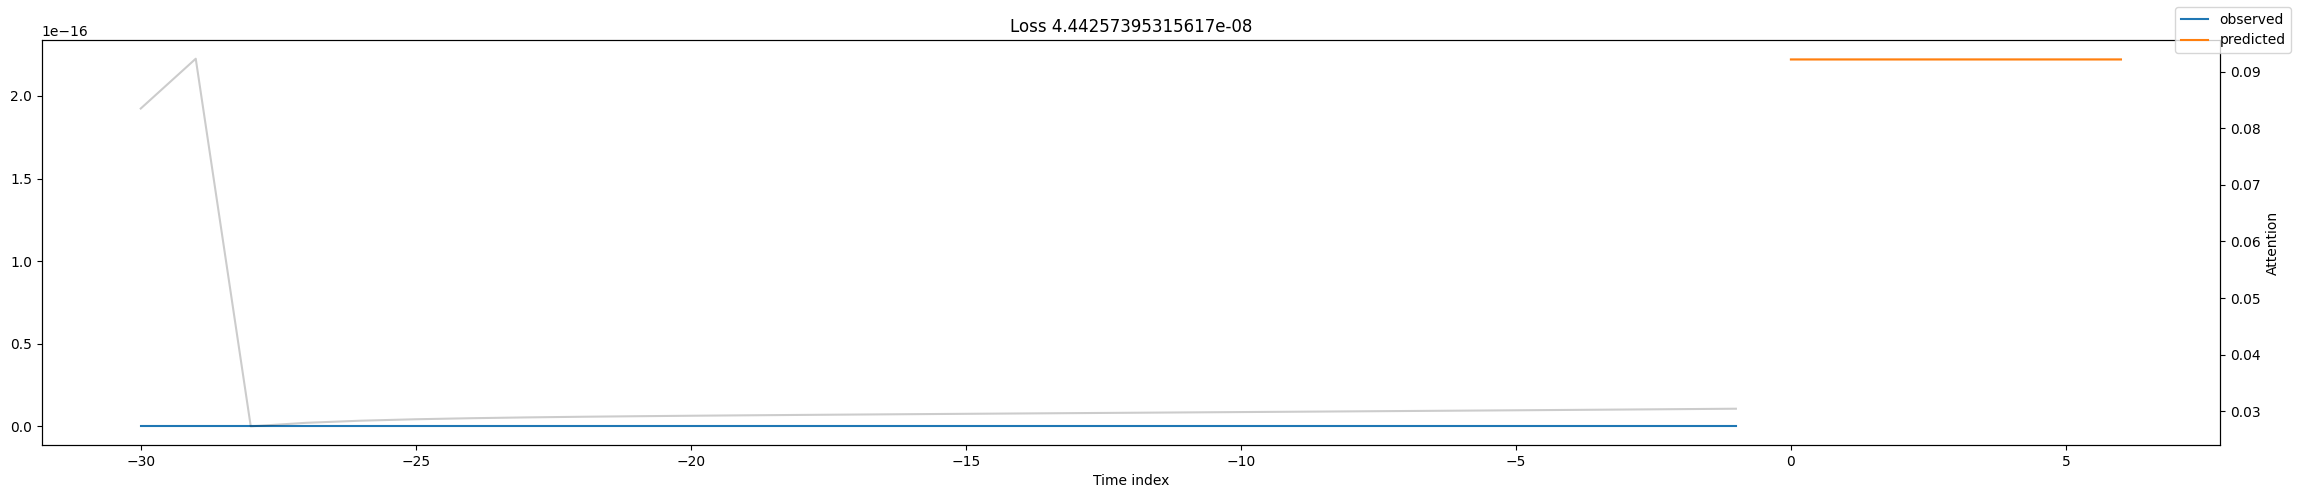

In [46]:
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(
        test_prediction_results.x, 
        test_prediction_results.output, 
        idx=idx, 
        show_future_observed=False,
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
        ax=ax,
        )

In [47]:
test_prediction_results.output.prediction.cpu().numpy().shape

(17, 7, 7)

In [48]:
test_prediction_results.index['locality']

0                Altona
1            Burns Lake
2                Chateh
3             Cleardale
4                Endako
5        Fort Good Hope
6           Fort Nelson
7            Fort Smith
8     Germansen Landing
9             MacKenzie
10          McLeod Lake
11        Meander River
12            Prespatou
13        Prophet River
14         Rainbow Lake
15           Vanderhoof
16              Wonowon
Name: locality, dtype: object

In [49]:
 print('Shape of test_prediction_results.output.prediction:', test_prediction_results.output.prediction.shape)

Shape of test_prediction_results.output.prediction: torch.Size([17, 7, 7])


In [50]:
print('Structure of test_prediction_results.index:\n', test_prediction_results.index)


Structure of test_prediction_results.index:
     time_idx           locality
0         59             Altona
1         59         Burns Lake
2         59             Chateh
3         59          Cleardale
4         59             Endako
5         59     Fort Good Hope
6         59        Fort Nelson
7         59         Fort Smith
8         59  Germansen Landing
9         59          MacKenzie
10        59        McLeod Lake
11        59      Meander River
12        59          Prespatou
13        59      Prophet River
14        59       Rainbow Lake
15        59         Vanderhoof
16        59            Wonowon


In [51]:
test_prediction_results.output.prediction.median(dim=1)

torch.return_types.median(
values=tensor([[2.2195e-16, 2.2202e-16, 2.2203e-16, 2.2207e-16, 2.2211e-16, 2.2222e-16,
         2.2252e-16],
        [4.7450e-17, 1.6372e-16, 1.8364e-16, 3.6078e-16, 7.2617e-16, 4.4828e-15,
         4.1093e-13],
        [2.2196e-16, 2.2202e-16, 2.2202e-16, 2.2206e-16, 2.2209e-16, 2.2219e-16,
         2.2246e-16],
        [3.3608e-19, 2.1648e-17, 4.7901e-17, 1.3881e-16, 6.6831e-16, 1.4342e-14,
         1.1133e-03],
        [1.3018e-16, 1.9984e-16, 2.0816e-16, 2.6112e-16, 3.3122e-16, 6.2456e-16,
         3.0621e-15],
        [1.6180e+01, 1.9863e+01, 2.0693e+01, 2.1194e+01, 2.1475e+01, 2.1757e+01,
         2.4121e+01],
        [2.7704e-26, 3.5276e-18, 1.5285e-17, 1.5426e-12, 2.5400e-07, 1.1839e+01,
         6.6209e+01],
        [5.0459e-23, 8.1041e-18, 1.7179e-17, 2.7729e-14, 3.1174e-11, 1.1628e-03,
         3.3158e+01],
        [6.2245e-18, 1.0981e-16, 1.3759e-16, 6.9881e-16, 3.6368e-15, 2.3471e-13,
         7.7030e-09],
        [1.0235e-24, 4.1731e-18, 2.0218

In [52]:
def map_predictions_to_dataframe(test_data, test_prediction_results):
    # Create a copy of the test data
    predictions_df = test_filled.copy()
    
    median_predictions, _ = test_prediction_results.output.prediction.median(dim=1)
    median_predictions = median_predictions.cpu().numpy()[:,1]
    
    # Print shape of median_predictions for debugging
    print('Shape of median_predictions:', median_predictions.shape)
    
    # Extract locality values from the index DataFrame
    locality_values = test_prediction_results.index['locality'].values
    
    # Print lengths for debugging
    print('Length of predictions_df:', len(predictions_df))
    print('Length of median_predictions:', len(median_predictions))
    print('Length of locality_values:', len(locality_values))
    
    # Ensure the lengths match
    if len(median_predictions) != len(locality_values):
        raise ValueError("Mismatch in lengths between median_predictions and test_prediction_results.index")
    
    # Create a mapping DataFrame from the test prediction results
    mapping_df = pd.DataFrame({
        'locality': locality_values,
        'cfb': median_predictions
    })

    # Merge the mapping DataFrame with the predictions DataFrame
    predictions_df = predictions_df.merge(mapping_df, on='locality', how='left', suffixes=('', '_pred'))
    
    return predictions_df

# Usage
predictions_df = map_predictions_to_dataframe(test_data, test_prediction_results)
print(predictions_df)

Shape of median_predictions: (17,)
Length of predictions_df: 1122
Length of median_predictions: 17
Length of locality_values: 17
     locality  time_idx     index   cfb        lat         lon       temp  \
0      Altona         0   10457.0   0.0  55.659277 -117.093903  18.424999   
1      Altona         1   10458.0   0.0  55.659277 -117.093903  18.424999   
2      Altona         2   10459.0   0.0  55.659277 -117.093903  18.424999   
3      Altona         3   10460.0   0.0  55.659277 -117.093903  18.424999   
4      Altona         4   10461.0   0.0  55.659277 -117.093903  18.424999   
...       ...       ...       ...   ...        ...         ...        ...   
1117  Wonowon        61  648283.0  83.0  56.831605 -121.863865  23.364000   
1118  Wonowon        62  648284.0  83.0  56.831605 -121.863865  23.364000   
1119  Wonowon        63  648285.0  83.0  56.831605 -121.863865  23.364000   
1120  Wonowon        64  648286.0  83.0  56.831605 -121.863865  23.364000   
1121  Wonowon        65 

In [53]:
predictions_df[['cfb', 'cfb_pred']]

,cfb,cfb_pred
0,0.0,2.220230e-16
1,0.0,2.220230e-16
2,0.0,2.220230e-16
3,0.0,2.220230e-16
4,0.0,2.220230e-16
...,...,...
1117,83.0,7.994560e+01
1118,83.0,7.994560e+01
1119,83.0,7.994560e+01
1120,83.0,7.994560e+01


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


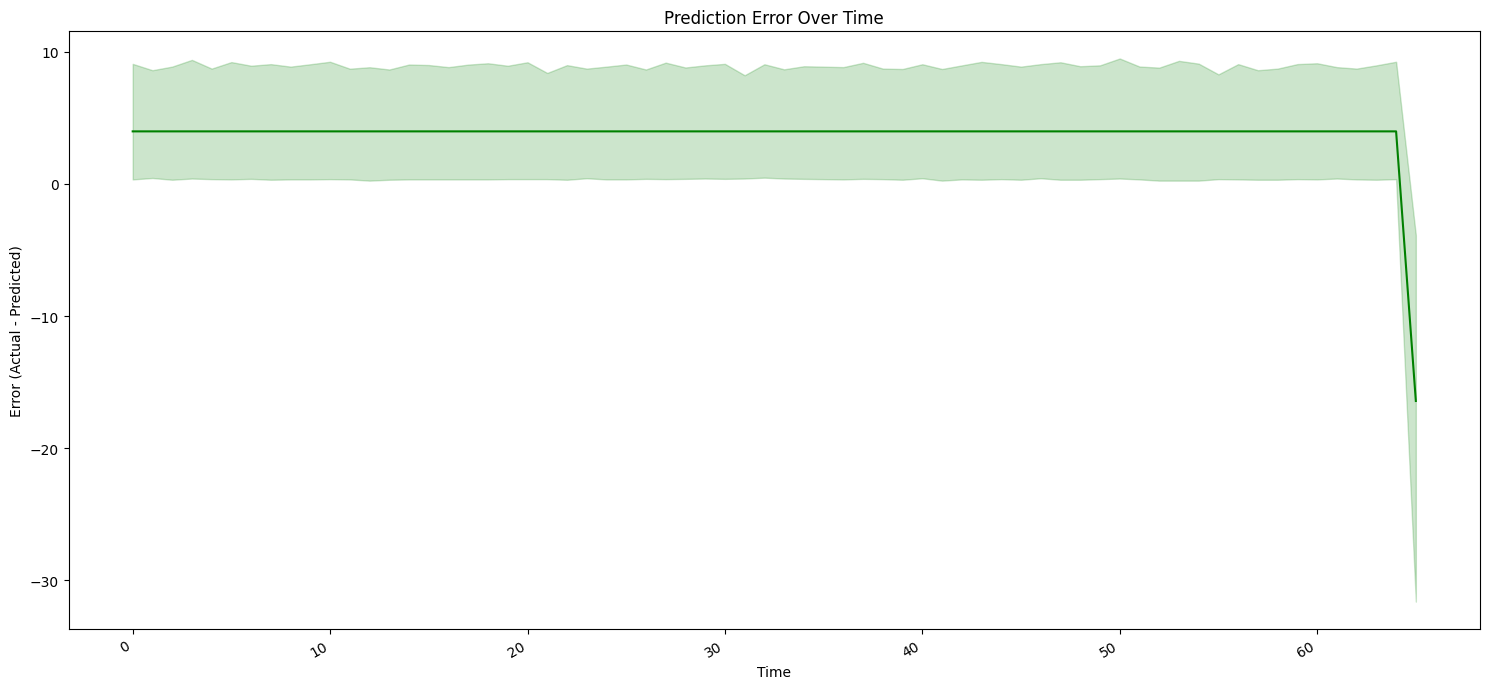

In [54]:
import seaborn as sns

plt.figure(figsize=(15, 7))
predictions_df['Difference'] = predictions_df['cfb'] - predictions_df['cfb_pred']
sns.lineplot(data=predictions_df, x='time_idx', y='Difference', color='green')

plt.title('Prediction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error (Actual - Predicted)')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate metrics
mae = mean_absolute_error(predictions_df['cfb'], predictions_df['cfb_pred'])
rmse = np.sqrt(mean_squared_error(predictions_df['cfb'], predictions_df['cfb_pred']))
# Define sMAPE function
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Compute sMAPE
smape_value = smape(predictions_df['cfb'], predictions_df['cfb_pred'])
print(f"sMAPE: {smape_value:.2f}%")

sMAPE: 147.48%


In [56]:
pip install -U kaleido

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
import plotly.graph_objects as go
import plotly.io as pio

# Create the scatter plot
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter(
    x=predictions_df['cfb'],
    y=predictions_df['cfb_pred'],
    mode='markers',
    marker=dict(
        size=10,
        color=predictions_df['cfb'],
        colorscale='YlOrRd',
        showscale=True,
        colorbar=dict(title='Actual Target Value')
    ),
    text=predictions_df['locality'],
    hovertemplate='<b>%{text}</b><br>Actual: %{x:.2f}<br>Predicted: %{y:.2f}<extra></extra>'
))

# Add perfect prediction line
max_value = max(predictions_df['cfb'].max(), predictions_df['cfb_pred'].max())
fig.add_trace(go.Scatter(
    x=[0, max_value],
    y=[0, max_value],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Predicted vs Actual Target Values by Location',
    xaxis_title='Actual Target Value',
    yaxis_title='Predicted Target Value',
    width=1000,
    height=800,
    hovermode='closest',
    annotations=[
        dict(
            x=0.05,
            y=0.95,
            xref='paper',
            yref='paper',
            text=f'MAE = {mae:.2f}<br>RMSE = {rmse:.2f}<br>SMAPE = {smape_value:.2f}%',
            showarrow=False,
            bgcolor='white',
            bordercolor='black',
            borderwidth=1
        )
    ]
)

# Update axes to be equal
fig.update_xaxes(range=[0, max_value])
fig.update_yaxes(range=[0, max_value])
fig.show()
# Save the plot as an interactive HTML file
pio.write_html(fig, file='interactive_wildfire_target_prediction.html', auto_open=True)

print("Interactive Plotly plot saved as 'interactive_wildfire_target_prediction.html'")

# # If you want to save as a static image as well
# fig.write_image("static_wildfire_target_prediction.png")
# print("Static image saved as 'static_wildfire_target_prediction.png'")

Interactive Plotly plot saved as 'interactive_wildfire_target_prediction.html'


In [58]:
locations = predictions_df.drop_duplicates(subset=['locality'])['locality']
locations

0                  Altona
66             Burns Lake
132                Chateh
198             Cleardale
264                Endako
330        Fort Good Hope
396           Fort Nelson
462            Fort Smith
528     Germansen Landing
594             MacKenzie
660           McLeod Lake
726         Meander River
792             Prespatou
858         Prophet River
924          Rainbow Lake
990            Vanderhoof
1056              Wonowon
Name: locality, dtype: object

In [59]:
len(locations)

17

In [60]:
# Print some statistics
print("\nStatistics:")
print(f"Number of locations: {len(locations)}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error: {smape_value:.2f}")
print("\nTop 5 locations with highest actual target values:")
print(predictions_df.sort_values('cfb_pred', ascending=False)[['locality', 'cfb', 'cfb_pred','time_idx']].head())


Statistics:
Number of locations: 17
Mean Absolute Error: 4.18
Root Mean Squared Error: 10.79
Symmetric Mean Absolute Percentage Error: 147.48

Top 5 locations with highest actual target values:
     locality   cfb   cfb_pred  time_idx
1061  Wonowon  83.0  79.945602         5
1062  Wonowon  83.0  79.945602         6
1097  Wonowon  83.0  79.945602        41
1100  Wonowon  83.0  79.945602        44
1101  Wonowon  83.0  79.945602        45
